# Two-dimensional discrete random value (DRV) generation 
## Katerina Zhevniak 853502

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Randomizer:
    def __init__(self):
        self.k = 5 ** 16
        self.m = 1 << 35
        self.A = 10

    def next(self):
        self.A = (self.A * self.k) % self.m
        return self.A / self.m

In [3]:
class DRV2D:
    def __init__(self, n, m, x, y):
        self.generator = Randomizer()
        self.n = n
        self.m = m
        self.x = x
        self.y = y
        self.theor = np.array([[1 / (n * m)] * m] * n)
        self.x_prob_t = [np.sum(self.theor[i, :]) for i in range(self.n)]
        self.y_prob_t = [np.sum(self.theor[:, i]) for i in range(self.m)]
        
    def get_distribution(self, exp_count):
        Z = np.zeros((self.n, self.m))
        
        for i in range(exp_count):
            x = self._next(self.generator, self.x_prob_t)
            y = self._next(self.generator, self.theor[x, :], self.x_prob_t[x])
            Z[x][y] += 1

        self.emp = np.array(Z) / np.sum(Z)
        self.total = exp_count
        self.x_emp = [np.sum(self.emp[i, :]) for i in range(n)]
        self.y_emp = [np.sum(self.emp[:, i]) for i in range(m)]
    
    @staticmethod
    def _next(gen, probabilities, max_prob=1):
        cur_prob = 0
        gen_prob = gen.next() * max_prob
        for i in range(len(probabilities)):
            cur_prob += probabilities[i]
            if cur_prob >= gen_prob:
                return i

In [4]:
n = 5
m = 5

In [5]:
def observe(n, m, x, y):
    def decorator(func):
        def inner(*args, **kwargs):
            dis = DRV2D(n, m, x, y)
            size = 100
            
            for exp_size in [size, size * 10, size * 100, size * 1000]:
                print('#' + '-' * 50)
                print('# n =', exp_size)
                print('#' + '-' * 50)
                dis.get_distribution(exp_size)
                func(dis)
        return inner
    return decorator

In [6]:
x = np.arange(n)
y = np.arange(m)

dis = DRV2D(n, m, x, y)
dis.get_distribution(1000)
print(dis.emp)
print(dis.x_emp)
print(dis.y_emp)


[[0.051 0.029 0.049 0.032 0.032]
 [0.043 0.032 0.043 0.045 0.04 ]
 [0.046 0.039 0.039 0.039 0.034]
 [0.057 0.033 0.037 0.037 0.034]
 [0.037 0.048 0.046 0.04  0.038]]
[0.193, 0.20299999999999999, 0.197, 0.198, 0.20900000000000002]
[0.234, 0.181, 0.21400000000000002, 0.193, 0.17800000000000002]


In [7]:
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{0:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords='offset points', 
                    ha='center', 
                    va='bottom',
                    rotation=90)

def plot_distr(n, emp, theor, title):
    xrange = np.arange(n)

    width = 0.425

    fig, ax = plt.subplots()

    rects_pract = ax.bar(xrange - width / 2, emp, width, label='Practical', color='Yellow')
    rects_theor = ax.bar(xrange + width / 2, theor, width, label='Theoretical', color='Green')

    autolabel(rects_pract)
    autolabel(rects_theor)

    ax.set_ylim((0, ax.get_ylim()[1] * 1.25))
    fig.tight_layout()

    ax.set_title(title)
    ax.set_xticks(xrange)
    ax.legend()
    plt.show()

In [8]:
@observe(n, m, x, y)
def plot_distributions(dis):
    plot_distr(dis.n, dis.x_emp, dis.x_prob_t, 'X')
    plot_distr(dis.m, dis.y_emp, dis.y_prob_t, 'Y')

#--------------------------------------------------
# n = 100
#--------------------------------------------------


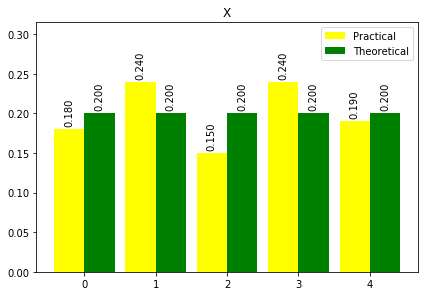

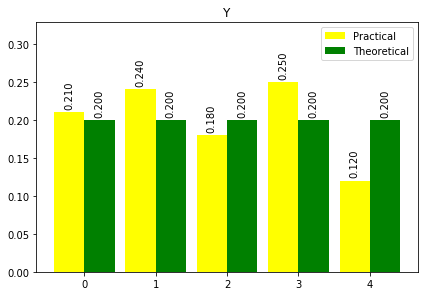

#--------------------------------------------------
# n = 1000
#--------------------------------------------------


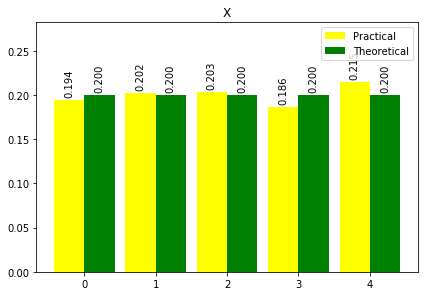

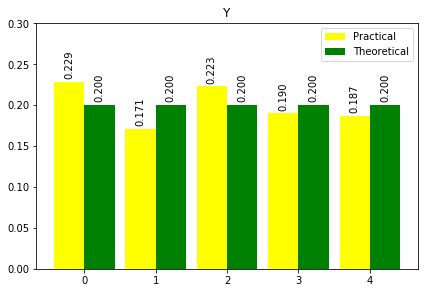

#--------------------------------------------------
# n = 10000
#--------------------------------------------------


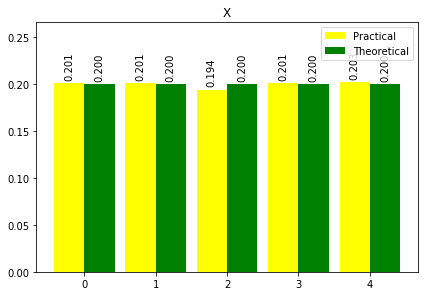

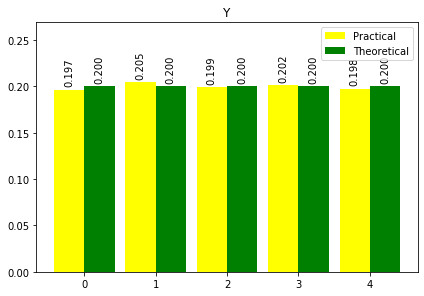

#--------------------------------------------------
# n = 100000
#--------------------------------------------------


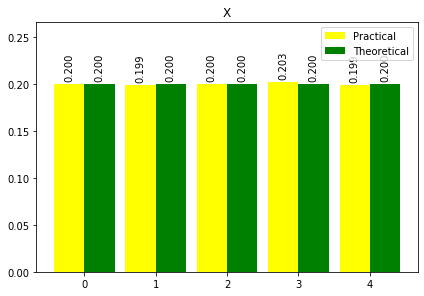

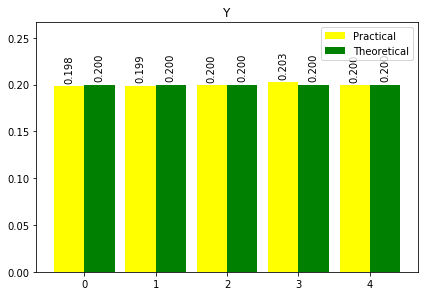

In [9]:
plot_distributions()

### Точечные оценки компонент

#### Матожидание

In [10]:
def get_expectation(mat, vals, axis=0):
    n, m = mat.shape
    res = 0
    for i in range(n):
        for j in range(m):
            val_id = j if axis else i
            res += mat[i, j] * vals[val_id]   
    return res

In [11]:
@observe(n, m, x, y)
def get_expectations(dis):
    m_x = get_expectation(dis.emp, dis.x)
    m_y = get_expectation(dis.emp, dis.y, 1)
    
    print('Empirical M[X]: {:.6}'.format(m_x))
    print('Empirical M[Y]: {:.6}'.format(m_y))

In [12]:
m_xt = get_expectation(dis.theor, dis.x)
m_yt = get_expectation(dis.theor, dis.y, 1)
print('Theoretical M[X]: {:.6}, Theoretical M[Y]: {:.6}'.format(m_xt, m_yt))
get_expectations()

Theoretical M[X]: 2.0, Theoretical M[Y]: 2.0
#--------------------------------------------------
# n = 100
#--------------------------------------------------
Empirical M[X]: 2.02
Empirical M[Y]: 1.83
#--------------------------------------------------
# n = 1000
#--------------------------------------------------
Empirical M[X]: 2.026
Empirical M[Y]: 1.935
#--------------------------------------------------
# n = 10000
#--------------------------------------------------
Empirical M[X]: 2.0035
Empirical M[Y]: 1.9987
#--------------------------------------------------
# n = 100000
#--------------------------------------------------
Empirical M[X]: 2.00164
Empirical M[Y]: 2.00693


#### Дисперсия

In [13]:
def get_dispersion(mat, vals, axis=0):
    n, m = mat.shape
    e_x = get_expectation(mat, vals, axis)
    res = 0
    for i in range(n):
        for j in range(m):
            val_id = j if axis else i
            res += mat[i, j] * (vals[val_id] - e_x)**2
    return res

In [14]:
@observe(n, m, x, y)
def get_dispersions(dis):
    d_x = get_dispersion(dis.emp, dis.x)
    d_y = get_dispersion(dis.emp, dis.y, 1)
    
    print('Empirical D[X]: {:.6}'.format(d_x))
    print('Empirical D[Y]: {:.6}'.format(d_y))

In [15]:
d_x_t = get_dispersion(dis.theor, dis.x)
d_y_t = get_dispersion(dis.theor, dis.y, 1)
print('Theoretical D[X]: {:.6}, Theoretical D[Y]: {:.6}'.format(d_x_t, d_y_t))
get_dispersions()

Theoretical D[X]: 2.0, Theoretical D[Y]: 2.0
#--------------------------------------------------
# n = 100
#--------------------------------------------------
Empirical D[X]: 1.9596
Empirical D[Y]: 1.7811
#--------------------------------------------------
# n = 1000
#--------------------------------------------------
Empirical D[X]: 2.02332
Empirical D[Y]: 2.02077
#--------------------------------------------------
# n = 10000
#--------------------------------------------------
Empirical D[X]: 2.01689
Empirical D[Y]: 1.9829
#--------------------------------------------------
# n = 100000
#--------------------------------------------------
Empirical D[X]: 1.99624
Empirical D[Y]: 1.99394


#### Корелляция

In [16]:
def get_expectation_xy(mat, xvals, yvals):
    n, m = mat.shape
    res = 0
    for i in range(n):
        for j in range(m):
            res += mat[i, j] * xvals[i] * yvals[j]
    return res

In [17]:
@observe(n, m, x, y)
def get_covariances(dis):
    m_x = get_expectation(dis.emp, dis.x)
    m_y = get_expectation(dis.emp, dis.y, 1)
    m_xy = get_expectation_xy(dis.emp, dis.x, dis.y)
    
    d_x = get_dispersion(dis.emp, dis.x)
    d_y = get_dispersion(dis.emp, dis.y, 1)

    covariance = m_xy - m_x * m_y
    r = covariance / (np.sqrt(d_x) * np.sqrt(d_y)) 
    
    print('r = {:.6}'.format(r))

In [18]:
get_covariances()

#--------------------------------------------------
# n = 100
#--------------------------------------------------
r = -0.13735
#--------------------------------------------------
# n = 1000
#--------------------------------------------------
r = 0.0221013
#--------------------------------------------------
# n = 10000
#--------------------------------------------------
r = 0.00705291
#--------------------------------------------------
# n = 100000
#--------------------------------------------------
r = -0.00561447


### Доверительные интервалы

In [19]:
from scipy import stats

def get_dispersion_borders(s, alpha, n):
    l = s * (n - 1) / stats.norm.ppf(1 - alpha / 2, n - 1)
    r = s * (n - 1) / stats.norm.ppf(alpha / 2, n - 1)
    return l, r

def get_exp_interval(s, val, n):
    return s * stats.norm.ppf(val) / np.sqrt(n)

#### 1. Доверительный интервал для матожидания

In [20]:
@observe(n, m, x, y)
def build_exp_intervals(dis):
    for alpha in [0.01, 0.05, 0.1, 0.3]:
        laplace_e = (1 - alpha)

        m_x = get_expectation(dis.emp, dis.x)
        m_y = get_expectation(dis.emp, dis.x, 1)
        m_xy = get_expectation_xy(dis.emp, dis.x, dis.y)

        d_x = get_dispersion(dis.emp, dis.x)
        d_y = get_dispersion(dis.emp, dis.y, 1)

        interval_len_x = get_exp_interval(d_x, laplace_e, n * m)
        interval_len_y = get_exp_interval(d_y, laplace_e, n * m)

        print(f'Interval for M(X) with alpha = {alpha} is ({m_x - interval_len_x}, {m_x + interval_len_x})')
        print(f'Interval for M(Y) with alpha = {alpha} is ({m_y - interval_len_y}, {m_y + interval_len_y})')
        print()

In [21]:
build_exp_intervals()

#--------------------------------------------------
# n = 100
#--------------------------------------------------
Interval for M(X) with alpha = 0.01 is (1.1082577412059136, 2.9317422587940865)
Interval for M(Y) with alpha = 0.01 is (1.0013083603091721, 2.658691639690829)

Interval for M(X) with alpha = 0.05 is (1.375348966525179, 2.6646510334748212)
Interval for M(Y) with alpha = 0.05 is (1.244070241007347, 2.415929758992654)

Interval for M(X) with alpha = 0.1 is (1.5177343104317602, 2.52226568956824)
Interval for M(Y) with alpha = 0.1 is (1.373485701321703, 2.286514298678298)

Interval for M(X) with alpha = 0.3 is (1.8144769510594647, 2.225523048940535)
Interval for M(Y) with alpha = 0.3 is (1.6431980493631422, 2.0168019506368586)

#--------------------------------------------------
# n = 1000
#--------------------------------------------------
Interval for M(X) with alpha = 0.01 is (1.084608902820838, 2.9673910971791617)
Interval for M(Y) with alpha = 0.01 is (0.9947948749670246, 2

#### 2. Доверительный интервал для дисперсии

In [22]:
@observe(n, m, x, y)
def build_dispersion_intervals(dis):
    for alpha_e in [0.01, 0.05, 0.1, 0.3]:
        laplace_e = (1 - alpha_e)
        
        d_x = get_dispersion(dis.emp, dis.x)
        d_y = get_dispersion(dis.emp, dis.y, 1)

        dx_l, dx_r = get_dispersion_borders(d_x, alpha_e, dis.total)
        dy_l, dy_r = get_dispersion_borders(d_y, alpha_e, dis.total)
        interval_len = get_exp_interval(d_x, laplace_e, dis.total)
        print(f'Interval length = {interval_len}')

        print(f'Interval for D(X) with alpha = {alpha_e} is ({dx_l}, {dx_r})')
        print(f'Interval for D(Y) with alpha = {alpha_e} is ({dy_l}, {dy_r})')
        print()

In [23]:
build_dispersion_intervals()

#--------------------------------------------------
# n = 100
#--------------------------------------------------
Interval length = 0.45587112939704316
Interval for D(X) with alpha = 0.01 is (1.9099071238714656, 2.0119478197092775)
Interval for D(Y) with alpha = 0.01 is (1.7359336488709263, 1.8286794558502726)

Interval length = 0.3223255167374105
Interval for D(X) with alpha = 0.05 is (1.9215577377752155, 1.999178977727222)
Interval for D(Y) with alpha = 0.05 is (1.746523008140149, 1.81707372791894)

Interval length = 0.2511328447841199
Interval for D(X) with alpha = 0.1 is (1.9275739693464968, 1.9927082155125437)
Interval for D(Y) with alpha = 0.1 is (1.7519912210670776, 1.8111923875532718)

Interval length = 0.10276152447026765
Interval for D(X) with alpha = 0.3 is (1.9392974482072516, 1.9803321450241507)
Interval for D(Y) with alpha = 0.3 is (1.762646808023033, 1.7999436535530284)

#--------------------------------------------------
# n = 1000
#-------------------------------------

### Критерий хи-квадрат

In [24]:
def get_emp_chi(theor, emp):
    n, m = emp.shape
    
    chi_val = 0
    for i in range(n):
        for j in range(m):
            chi_val += (theor[i, j] - emp[i, j]) ** 2 / theor[i, j]
    
    return chi_val

In [25]:
from scipy.stats import chi2
from math import log10

@observe(n, m, x, y)
def build_chi_criteria(dis):
    alpha = 0.05
    n = dis.total
    
    emp_chi = get_emp_chi(dis.theor, dis.emp) * dis.n * dis.m
    theor_chi = chi2.isf(alpha, 3 * log10(n) - 1)
    
    print(f'alpha = {alpha}')
    if emp_chi < theor_chi:
        print(True, ': {:.6}'.format(emp_chi), ' < {:.6}\n'.format(theor_chi), sep='')
    else:
        print(False, ': {:.6}'.format(emp_chi), ' > {:.6}\n'.format(theor_chi), sep='')

In [26]:
build_chi_criteria()

#--------------------------------------------------
# n = 100
#--------------------------------------------------
alpha = 0.05
True: 10.125 < 11.0705

#--------------------------------------------------
# n = 1000
#--------------------------------------------------
alpha = 0.05
True: 0.635 < 15.5073

#--------------------------------------------------
# n = 10000
#--------------------------------------------------
alpha = 0.05
True: 0.041775 < 19.6751

#--------------------------------------------------
# n = 100000
#--------------------------------------------------
alpha = 0.05
True: 0.00583225 < 23.6848

